Check the dynamics in cluster (use rcluster_id)

In [362]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.cluster import KMeans
from importlib import reload
from tqdm.notebook import tqdm, trange

plt.rcParams["figure.facecolor"] = "w"

import sys
sys.path.append("../../include/")
import hhtools
import hhsignal
import xarray as xr

import utils
import hhclustering as hc
reload(utils)
reload(hc)
reload(hhtools)

<module 'hhtools' from '/home/jungyoung/Project/hh_neuralnet/three_pop_mpi/clustering/../../include/hhtools.py'>

In [352]:
# Load data
summary_obj = hhtools.SummaryLoader("../simulation_data/data", load_only_control=False)

with open('../simulation_data/collected_data.pkl', "rb") as fp:
    post_data = pkl.load(fp)

align_data, row_names, col_names = utils.concat_data(post_data, key_to_rm=[], include_std=True, show_mm_scale=False, norm_mm=False)
row_labels = utils.mapping(row_names)
    
with open("../simulation_data/purified_data.pkl", "rb") as fp:
    pdata = pkl.load(fp)
    
# load cluster
with open("./data/rcluster_nrank3_inc_im.pkl", "rb") as fp:
    cluster_data = pkl.load(fp)
# rcluster_id = buf["rcluster_id"]

# validity
if align_data.shape[1] != len(cluster_data["rcluster_id"]):
    raise ValueError("Size does not match")
    
def finder(target_row, row_names):
    return row_names.index(target_row)

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
skipped overlap key: dphi_std
datadim: (45, 4725), nrow: 45, ncol: 4725
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']


# Single sample results 

In [353]:
N = 2000
clusters = np.unique(cluster_data["rcluster_id"])
pts_c = [np.where(cluster_data["rcluster_id"] == cid)[0].astype(int) for cid in clusters]
pts_id_sort = [pt[np.argsort(cluster_data["rsval"][pt]).astype(int)] for pt in pts_c]

def picker(cid, nbest=0):
    return pts_id_sort[cid-1][nbest]

def read_cluster_sample(cid, nbest=0, nitr=0):
    nid = picker(cid, nbest)
    tag, nr, nc = col_names[nid]
    nrank, nw = int(tag[2]), int(tag[5])
    nid_obj = [nr, nc, nrank, nw, nitr]
    return summary_obj.load_detail(*nid_obj)

In [354]:
detail_data = read_cluster_sample(8, 3)

np.random.seed(200)
xl = (3000, 4000)

plt.figure(dpi=120, figsize=(8, 4))

plt.axes(position=[0.05, 0.7, 0.41, 0.28])
hhtools.draw_spk(detail_data["step_spk"], xl=xl,
                 sequence=np.random.choice(N, size=1000, replace=False),
                 colors='k', ms=1, edgecolors='none')
plt.yticks([0, 500, 1000])

plt.axes(position=[0.54, 0.7, 0.41, 0.28])
hhtools.draw_spk(detail_data["step_spk"], xl=xl,
                 sequence=np.concatenate((np.arange(400), np.arange(800, 900), np.arange(1000, 1400), np.arange(1800, 1900))),
                 color_ranges=[400, 500, 900, 1000],
                 colors=["r", "b", "m", "g"], ms=1, edgecolors="none")
plt.yticks([0, 500, 1000], labels=["", "", ""])

plt.axes(position=[0.05, 0.1, 0.9, 0.5])
psd, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][0], detail_data["ts"], 2000, mbin_t=0.05, wbin_t=1, frange=(3, 90))
hhtools.imshow_xy(psd, x=tpsd*1e3, y=fpsd, cmap="jet", interpolation="spline16")
plt.ylim([15, 80])

plt.show()

# Total population

In [355]:
selected_rows = ("ac2p_1st(0)", "ac2p_large(0)", "1/tau_1st(0)", "1/tau_large(0)",
                 "ac2p_1st_std(0)", "ac2p_large_std(0)", "tau_1st_std(0)", "tau_large_std(0)")

picked_data = np.array([align_data[finder(r, row_names), :] for r in selected_rows])
# min-max scaling
pmin = np.min(picked_data, axis=1)[:, np.newaxis]
pmax = np.max(picked_data, axis=1)[:, np.newaxis]

picked_data = (picked_data - pmin) / (pmax - pmin)
ordered_pdata, id_sort, bds = hc.reorder_data(picked_data, cluster_data["rcluster_id"], sval=cluster_data["rsval"])
row_labels = utils.mapping(list(selected_rows))

## Ordered data 

In [ ]:
plt.figure(figsize=(6, 8), dpi=80)

s_data = hc.hsmooth(ordered_pdata, wsize=20, fo=2)
# s_data = ordered_pdata

plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(s_data.shape[0]), labels=row_labels)
# make boundary
plt.grid(True, lw=0.8, c='k', linestyle='--', axis="x")
for n in range(len(selected_rows)):
    plt.plot([0, s_data.shape[1]], [n+0.5, n+0.5], c='k', linestyle="--")
plt.xlim([0, s_data.shape[1]])
plt.show()

In [ ]:
norm_arr = np.sqrt(np.sum(ordered_pdata**2, axis=0))
norm_mat = ordered_pdata / norm_arr[np.newaxis, :]
sim_indiv = norm_mat.T @ norm_mat

K = len(bds)
edges = [0] + bds
sim_cluster = np.zeros([K, K])
for i in range(K):
    for j in range(K):
        sim_cluster[i, j] = np.average(sim_indiv[edges[i]:edges[i+1], edges[j]:edges[j+1]])

## use data from spectrogram 

In [487]:
def dflat(data):
    fdata = []
    for i in range(data.shape[2]):
        for j in range(data.shape[3]):
            fdata.extend(data[:,:,i,j].flatten())
    return np.array(fdata)


dyn_data = xr.open_dataarray("../dynamic_order2.nc")

In [472]:
align_total = []
keys = []
flag_key = True

for k in ("chi", "frs_m", "cv"):
    x = np.average(summary_obj.summary[k][:,:,:,:,:,0], axis=4).flatten()
    align_total.append(x)
    keys.append(k+"(T)")

key2read_fs = ("ac2p_large", "tlag_large", "ac2p_1st", "tlag_1st")
for dtype in ["mean", "std"]:
    for k in key2read_fs:
        align_total.append(dflat(dyn_data.sel(key=k, pop="T", type=dtype).to_numpy()))
        if flag_key: keys.append(k+"(T)")
    
    for tp in ["F", "S"]:
        for k in ("pwr_1st", "pwr_large"):
            align_total.append(dflat(dyn_data.sel(key=k, pop=tp, type=dtype).to_numpy()))
            if flag_key: keys.append(k+"(%s)"%(tp))
            
flag_key = False
        
align_total = np.array(align_total)

# normalize
nmax = np.max(align_total, axis=1)[:, np.newaxis]
nmin = np.min(align_total, axis=1)[:, np.newaxis]
align_total = (align_total - nmin) / (nmax - nmin)

In [473]:
K = 15

id_itr = 4

cluster_id = cluster_data["rcluster_id"]
rsval = cluster_data["rsval"]
reordered_data, id_sort, bds = hc.reorder_data(align_total, cluster_id, rsval)

plt.figure(figsize=(6, 8), dpi=120)
s_data = hc.hsmooth(reordered_data)
plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(s_data.shape[0]), labels=keys)
plt.grid(True, lw=0.8, c='k', linestyle='--')

bds0 = [0] + bds
for n in range(len(bds0)-1):
    x = (bds0[n] + bds0[n+1])/2
    plt.text(x, -0.8, "%d"%(n+1), fontsize=12, ha="center")
plt.text(-150, -0.8, "cid", fontsize=12, ha="center")

plt.tight_layout()
plt.colorbar(shrink=0.2)
# plt.savefig("./fig/filtered_cluster_nc=15_20230705.png")
plt.show()

15


## Predict the cluster only using total population results

### check the variance for each variable 

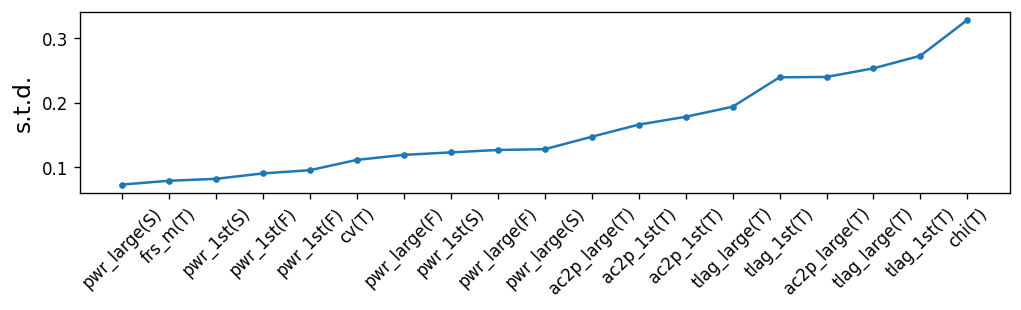

In [486]:
t_std = np.std(align_total, axis=1)
id_sort = np.argsort(t_std)

plt.figure(dpi=120, figsize=(10, 2))
plt.plot([t_std[i] for i in id_sort], '.-')
plt.xticks(np.arange(len(t_std)), labels=[keys[i] for i in id_sort], rotation=45)
plt.ylabel("s.t.d.", fontsize=14)
plt.show()

### Remove pwr related values 

In [603]:
ralign_total = []

for k in ("chi", "frs_m"):
    ralign_total.append(dflat(np.average(summary_obj.summary[k][:,:,:,:,:,0], axis=4)))
ralign_total.append(dflat(np.std(summary_obj.summary["chi"][:,:,:,:,:,0], axis=4)))
ralign_total.append(dflat(np.average(summary_obj.summary["frs_s"][:,:,:,:,:,0], axis=4)))
keys = ["chi(0)", "frs(0)", "chi_std(0)", "frs_std(0)"]


key2read_fs = ("ac2p_large", "tlag_large", "ac2p_1st", "tlag_1st")
for dtype in ["mean", "std"]:
    for k in key2read_fs:
        ralign_total.append(dflat(dyn_data.sel(key=k, pop="T", type=dtype).to_numpy()))
        if "tlag" in k:
            ralign_total[-1] = 1/ralign_total[-1]
            k = "1/" + k
        if dtype == "mean":
            keys.append(k+"(0)")
        else:
            keys.append(k+"_std(0)")
        
ralign_total = np.array(ralign_total)

# normalize
nmax = np.max(ralign_total, axis=1)[:, np.newaxis]
nmin = np.min(ralign_total, axis=1)[:, np.newaxis]
ralign_total = (ralign_total - nmin) / (nmax - nmin)

with open("../simulation_data/total_pop_data.pkl", "wb") as fp:
    pkl.dump({"data": ralign_total,
              "col_names": pdata["col_names"],
              "row_names": keys,
              "row_labels": utils.mapping(keys)}, fp)

In [595]:
km_obj, sval, scoeff = hc.kmeans_specific_seed(15, ralign_total, 200)

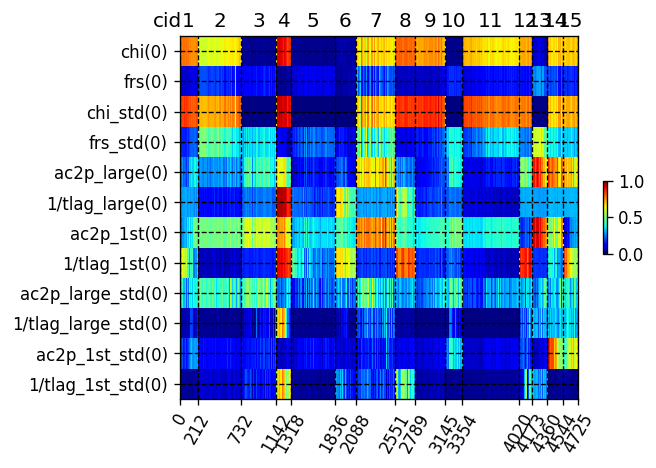

In [596]:
K = 15
reordered_data, id_sort, bds = hc.reorder_data(ralign_total, cids, sval)

plt.figure(figsize=(6, 4), dpi=120)
s_data = hc.hsmooth(reordered_data)
plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none", vmin=0, vmax=1)
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(s_data.shape[0]), labels=keys)
plt.grid(True, lw=0.8, c='k', linestyle='--')

bds0 = [0] + bds
for n in range(len(bds0)-1):
    x = (bds0[n] + bds0[n+1])/2
    plt.text(x, -0.8, "%d"%(n+1), fontsize=12, ha="center")
plt.text(-150, -0.8, "cid", fontsize=12, ha="center")

plt.tight_layout()
plt.colorbar(shrink=0.2)
plt.show()

In [590]:
utils.mapping(keys)

['$\\chi(T)$',
 '$frs(T)$',
 '$\\sigma[\\chi(T)]$',
 '$\\sigma[frs(T)]$',
 '$A_{large}(T)$',
 '$tlag_large(T)$',
 '$A_1(T)$',
 '$tlag_1st(T)$',
 '$\\sigma[A_{large}(T)]$',
 '$\\sigma[tlag_large(T)]$',
 '$\\sigma[A_1(T)]$',
 '$\\sigma[tlag_1st(T)]$']

In [ ]:
with open("../simulation_data/total_pop_data.pkl", 

In [526]:
cids_r = hc.realign_cluster(cids, col_names, num_r=3, num_w=7, ld=15,
                                 denoise=True, nth_remain=5)
rsval, rscoeff = hc.get_silhouette_scores(ralign_total, cids_r)

In [575]:
cvt_table

[3, 2, 4, 11, 6, 7, 10, -1, -1, 12, 14, 8, 9, 13, 15]

In [586]:
mat_overlap = np.zeros([K+1, K+1])
for id_n in range(1, K+1):
    for id_t in range(1, K+1):
        eq1 = cluster_data["rcluster_id"]==id_n
        eq2 = cids_r==id_t
        mat_overlap[id_n, id_t] = np.sum(eq1 & eq2) / np.max([np.sum(eq1), np.sum(eq2)])
        
# c_prev_re = np.zeros_like(c_prev) * np.nan
cids_tre = np.zeros_like(cids_r) * np.nan
cvt_table = [np.argmax(mat_overlap[:, n]) for n in range(1, K+1)]
# for i in range(K):
#     for j in range(i+1, K):
#         if cvt_table[i] == cvt_table[j]:
#             n = cvt_table[i]
#             if mat_overlap[n, i+1] > mat_overlap[n, j+1]:
#                 nc = j
#             else:
#                 nc = i
#             cvt_table[nc] = -1

# while len(np.unique(cvt_table)) != K:
#     escape = False
#     for i in range(K):
#         for j in range(i+1, K):
#             if cvt_table[i] == cvt_table[j]:
#                 n = cvt_table[i]
#                 if mat_overlap[n, i+1] > mat_overlap[n, j+1]:
#                     nc = j
#                 else:
#                     nc = i
#                 cvt_table[nc] = -1
#                 escape = True
#                 break
#         if escape: break

# if len(np.unique(cvt_table)) != K:
    # raise ValueError("some clusters are overlapped")
    # pass
    
print({i+1: cvt_table[i] for i in range(len(cvt_table))})    
for n in range(1, K+1):
    if cvt_table[n-1] == -1: continue
    cids_tre[cids_r == n] = cvt_table[n-1]

{1: 3, 2: 2, 3: 4, 4: 11, 5: 6, 6: 7, 7: 10, 8: 11, 9: 10, 10: 12, 11: 14, 12: 8, 13: 9, 14: 13, 15: 15}


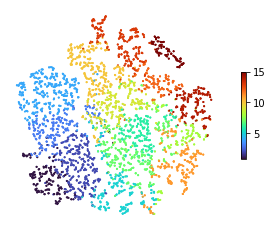

In [587]:
embed_data(cluster_data["rcluster_id"], cmap="turbo", vmax=1, vmin=15)

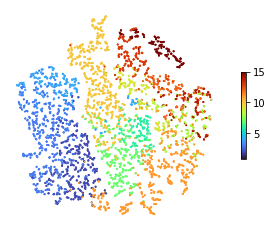

In [588]:
embed_data(cids_tre, cmap="turbo", vmax=1, vmin=15)

In [582]:
from copy import deepcopy

cmap = plt.get_cmap("tab20", K)
cmap_r = deepcopy(cmap)
# cmap_r.colors[cid_rm-1,:] = 0

plt.figure(dpi=120, figsize=(9, 4))

plt.subplot(121)
draw_with_tsne2d(s=2, c=rcluster_id, cmap=cmap)
plt.title("New cluster", fontsize=14)
utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)

plt.subplot(122)
draw_with_tsne2d(s=2, c=cids_tre, cmap=cmap_r)
plt.title("Old cluster", fontsize=14)
utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)

utils.save_fig("Cluster_compare_rank23")
plt.show()

NameError: name 'draw_with_tsne2d' is not defined

In [581]:
any(np.isnan(cids_tre))

True

In [ ]:
# calculate similarity between new and old clusters: how many points are overlapped
kold, knew = prev_cluster["K"], K
mat_overlap = np.zeros([knew+1, kold+1])
for id_n in range(knew+1):
    for id_o in range(kold+1):
        mat_overlap[id_n, id_o] = np.sum((rcluster_id==id_n) & (c_prev == id_o))
        
# relalign prev cluster id depending on 'mat_overlap'
c_prev_re = np.zeros_like(c_prev) * np.nan
cvt_table = [np.argmax(mat_overlap[:, n]) for n in range(1, kold+1)]
if len(np.unique(cvt_table)) != prev_cluster["K"]:
    raise ValueError("some clusters are overlapped")

print({i+1: cvt_table[i] for i in range(len(cvt_table))})    
for n in range(1, prev_cluster["K"]+1):
    c_prev_re[c_prev == n] = cvt_table[n-1]

# removed clusters
cid_rm = np.array([i for i in range(1, knew+1) if i not in cvt_table]).astype(int)

## Similarity

In [ ]:
plt.figure(dpi=120, figsize=(5, 5))
hhtools.imshow_xy(sim_cluster, x=np.arange(1, K+1), y=np.arange(1, K+1), cmap="jet", vmin=0.5, vmax=1, interpolation="none")
plt.axis("square")
plt.colorbar(shrink=0.8)
plt.xticks(np.arange(1, K+1, 2))
plt.yticks(np.arange(1, K+1, 2))

for i in range(1, K+1):
    plt.plot([i-0.5, i-0.5], [0.5, 15.5], 'k-', lw=0.5)
    plt.plot([0.5, 15.5], [i-0.5, i-0.5], 'k-', lw=0.5)

plt.show()

## Cluster merging

### Test 

In [ ]:
sys.path.append("../")
import postprocessing as pp
from tqdm.notebook import trange

In [ ]:
detail_data = read_cluster_sample(10, 200)

# get AC2
ac2_data = np.zeros([2, 4])
ac2_name = ("ac2p_large", "1/tlag_large", "ac2_1st", "1/tlag_1st")
for tp in range(1, 3):
    ac2_data[tp-1, :] = pp.get_ac2_peak(detail_data["vlfp"][tp], prominence=0.05)
# flip
for i in range(2):
    ac2_data[:, 2*i+1] = 1/ac2_data[:, 2*i+1]
    
# get PSD
# cut
idt = detail_data["ts"] > 0.5
psd, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][0][idt], detail_data["ts"][idt], 2000, mbin_t=0.01, wbin_t=1, frange=(3, 100))

In [ ]:
pwrs = []
for tp in range(2):
    for i in range(2):
        nf = np.argmin(np.abs(fpsd - ac2_data[tp, 2*i+1]))
        pwrs.append(np.average(psd[nf, :]))

In [ ]:
plt.figure(dpi=120)
plt.plot(fpsd, np.average(psd, axis=1), c='k')
yl = plt.ylim()
for tp in range(2):
    for i in range(2):
        plt.plot([ac2_data[tp, 2*i+1]]*2, yl, zorder=-1)
plt.ylim(yl)
plt.show()

In [ ]:
df = xr.load_dataarray("../../three_pop_mpi/dynamic_orders.nc")

# Visualize Cluster 

In [ ]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


lines_cluster = []
for idp in range(7):
    for idr in range(3):
        lines_cluster.append(get_im_boundary(cluster_data["im_stacks"][idr][idp]))

In [ ]:
len_p = 0.95/7
len_r = 0.95/3

xy = np.arange(15)

plt.figure(dpi=120, figsize=(14, 6))
for idp in range(7):
    for idr in range(3):
        ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
        
        im = cluster_data["im_stacks"][idr][idp]
        hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=3, vmin=1, vmax=15, fontsize=8, aspect="auto")
        for l in lines_cluster[idp*3+idr]:
            plt.plot(l[0], l[1], 'w', lw=1)
        
        plt.xticks([0, 7, 14], labels=["", "", ""])
        plt.yticks([0, 7, 14], labels=["", "", ""])
        plt.xlim([-0, 14]); plt.ylim([0, 14])
        
        
        for n, k in enumerate(("left", "right", "bottom", "top")):
            ax.spines[k].set_color("k")
        
        # ax.spines['bottom'].set_color('blue')
        # ax.spines['left'].set_color('red') 
        # ax.spines["bottom"].set_linewidth(2.5)
        # ax.spines["left"].set_linewidth(2.5)
        # ax.plot(1, 0, ">b", transform=ax.get_yaxis_transform(), clip_on=True)
        # ax.plot(0, 1, "^r", transform=ax.get_xaxis_transform(), clip_on=True)
    # break
            
plt.show()

# Embed the data into 2-D tSNE result

## Find the proper tSNE coordinates 

In [396]:
with open("./tsne_out.pkl", "rb") as fp:
    tsne_out = pkl.load(fp)
print(tsne_out.keys())

tfit = np.array(tsne_out["tsne_data"])

dict_keys(['tsne_data', 'params', 'seeds', 'perplexities'])


In [410]:
nrow = len(tsne_out["seeds"])
ncol = len(tsne_out["perplexities"])
wr = 0.95 / nrow
wc = 0.95 / ncol

plt.figure(figsize=(9, 12), dpi=150)
n = 0
for r in range(nrow):
    for c in range(ncol):
        plt.axes(position=[0.025+wc*c, 0.025+wr*(nrow-r), wc, wr])
        plt.scatter(tfit[n][:,0], tfit[n][:,1], s=0.5, c=cluster_data["rcluster_id"], cmap=plt.get_cmap("turbo", 15))
        plt.axis("off")
        n += 1
    # break

## Run 

In [411]:
# from sklearn.manifold import TSNE

# np.random.seed(200)
# tsne2d = TSNE(n_components=2, init="pca", n_jobs=20)
# tsne_fit = tsne2d.fit_transform(pdata["data"].copy().T)
tsne_fit = tfit[0].copy()

In [412]:
def embed_data(data, cmap="turbo", vmax=None, vmin=None):
    # plt.figure(dpi=120, figsize=(5, 5))
    plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], s=1, c=data, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.axis("square")
    ticks = [vmin, vmax] if vmin is not None and vmax is not None else None
    cbar = plt.colorbar(shrink=0.4)
    # cbar = plt.colorbar(shrink=0.6, format=lambda x, pos: "{:0.1e}".format(x) if x != 0 else "0")
    cbar.ax.locator_params(nbins=3)
    
pop_labels = ("Total", "Fast", "Slow")

In [413]:
plt.figure(dpi=120, figsize=(5, 5))
# plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], s=1, c=cluster_data["rcluster_id"], cmap=plt.get_cmap("tab20", 15))
plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], s=1, c=cluster_data["rcluster_id"], cmap=plt.get_cmap("turbo", 15))
plt.axis("off")
plt.axis("square")
utils.draw_categorical_colorbar(n_category=15, label="Cluster id", shrink=0.6)
plt.show()

In [414]:
centers = []
for nc in range(1, 16):
    ic = np.array(cluster_data["rcluster_id"]) == nc
    svals = cluster_data["rsval"][ic]
    p = (svals - np.min(svals)) / (np.max(svals) - np.min(svals))
    tsne_sub = tsne_fit[ic, :]
    centers.append(np.sum(tsne_sub * p[:, np.newaxis], axis=0) / np.sum(p))
centers = np.array(centers)

In [415]:
vor = Voronoi(centers)
cmap = plt.get_cmap("tab20", 15)

plt.figure(dpi=120, figsize=(6, 6))
voronoi_plot_2d(vor, show_vertices=False, line_colors='k', ax=plt.gca(),
                line_width=1, line_alpha=0.2, point_size=2)

# colorize
nc = 0
for region in vor.regions:
    if len(region) == 0: continue
    polygon = [vor.vertices[i] for i in region]
    plt.fill(*zip(*polygon), c=cmap((nc+1)/15), alpha=0.2)
    nc += 1

plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], s=1, c=cluster_data["rcluster_id"], cmap=cmap, zorder=10)

plt.axis("square")
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.show()

### Firing rate of each population

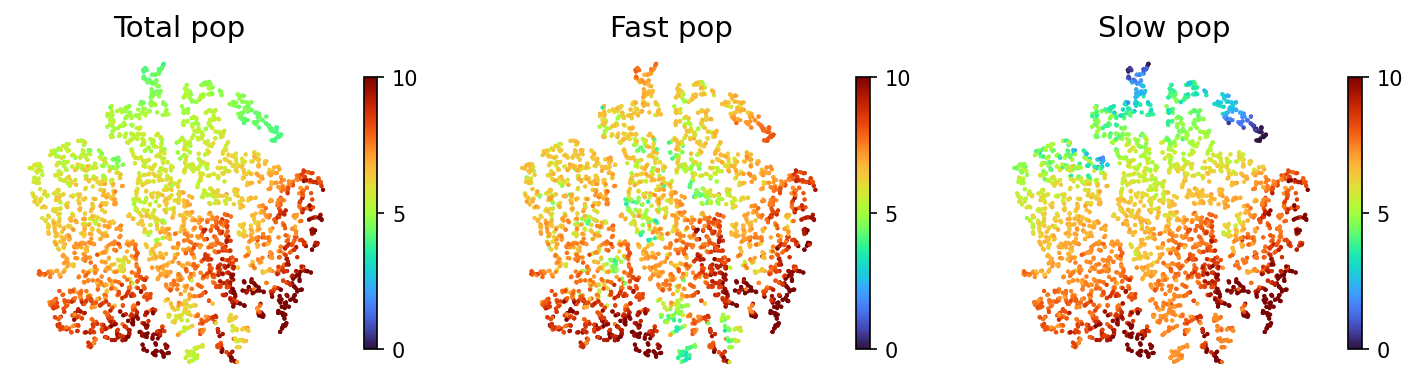

In [416]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("frs_m(%d)"%(tp), row_names)
    chi = align_data[nid, :]
    
    plt.subplot(1, 3, tp+1)
    embed_data(chi, cmap="turbo", vmin=0, vmax=10)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

### Synchrony of each population

In [417]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("chi(%d)"%(tp), row_names)
    chi = align_data[nid, :]
    
    plt.subplot(1, 3, tp+1)
    embed_data(chi, cmap="turbo", vmin=0, vmax=0.4)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

### Frequency of each population (1st)

In [418]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("1/tau_1st(%d)"%(tp), row_names)
    
    plt.subplot(1, 3, tp+1)
    embed_data(align_data[nid, :], cmap="turbo", vmin=20, vmax=80)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

### Frequency of each population (Large)

In [419]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("1/tau_large(%d)"%(tp), row_names)
    print(row_names[nid])
    
    plt.subplot(1, 3, tp+1)
    embed_data(align_data[nid, :], cmap="turbo", vmin=20, vmax=80)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

1/tau_large(0)
1/tau_large(1)
1/tau_large(2)


### Frequency difference 

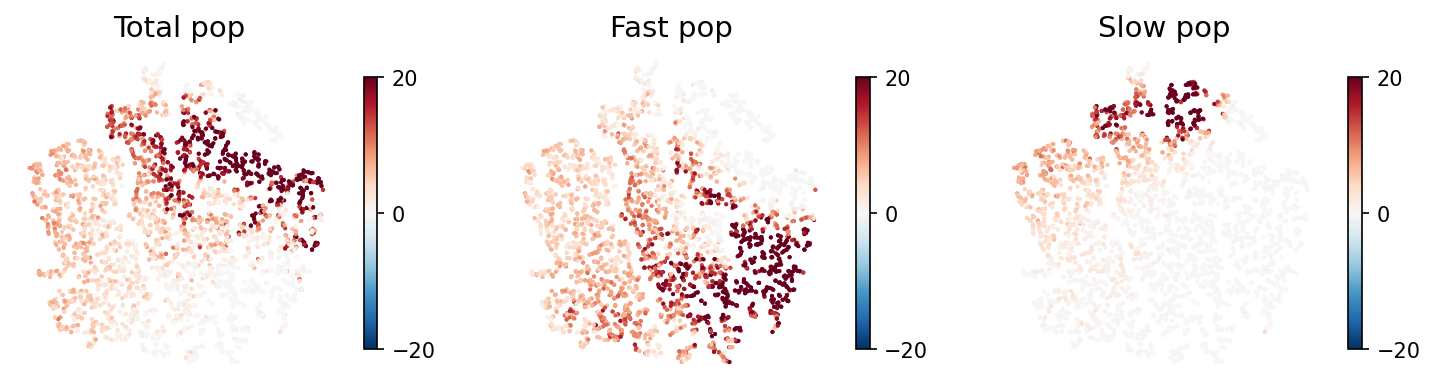

In [420]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("1/tau_large(%d)"%(tp), row_names)
    freq_large = align_data[nid, :]
    
    nid = finder("1/tau_1st(%d)"%(tp), row_names)
    freq_1st = align_data[nid, :]
    
    plt.subplot(1, 3, tp+1)
    embed_data(freq_1st - freq_large, cmap="RdBu_r", vmin=-20, vmax=20)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

### Regularity of the oscillation (1st) 

ac2p_1st(0)
ac2p_1st(1)
ac2p_1st(2)


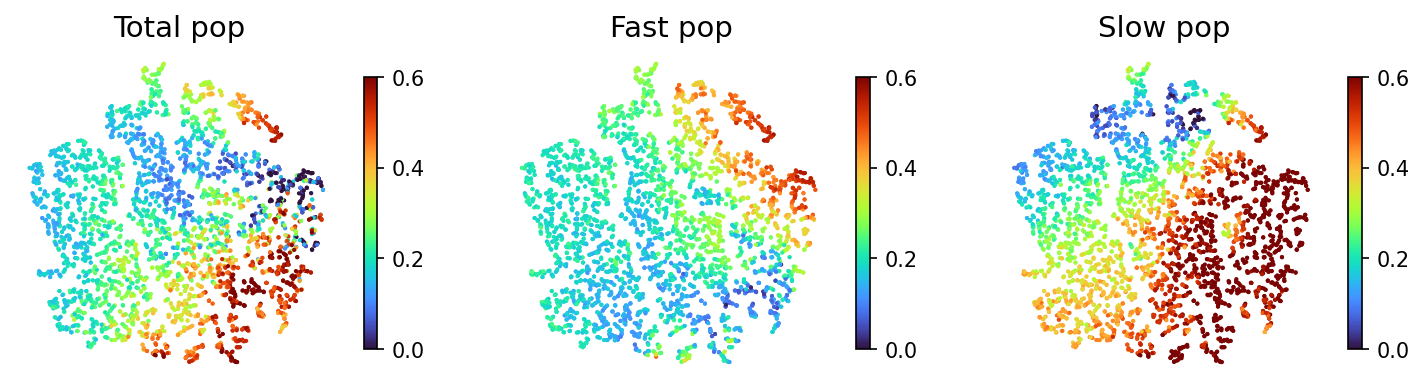

In [421]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("ac2p_1st(%d)"%(tp), row_names)
    print(row_names[nid])
    
    plt.subplot(1, 3, tp+1)
    embed_data(align_data[nid, :], cmap="turbo", vmin=0, vmax=0.6)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

### Regularity of the oscillation (large) 

ac2p_large(0)
ac2p_large(1)
ac2p_large(2)


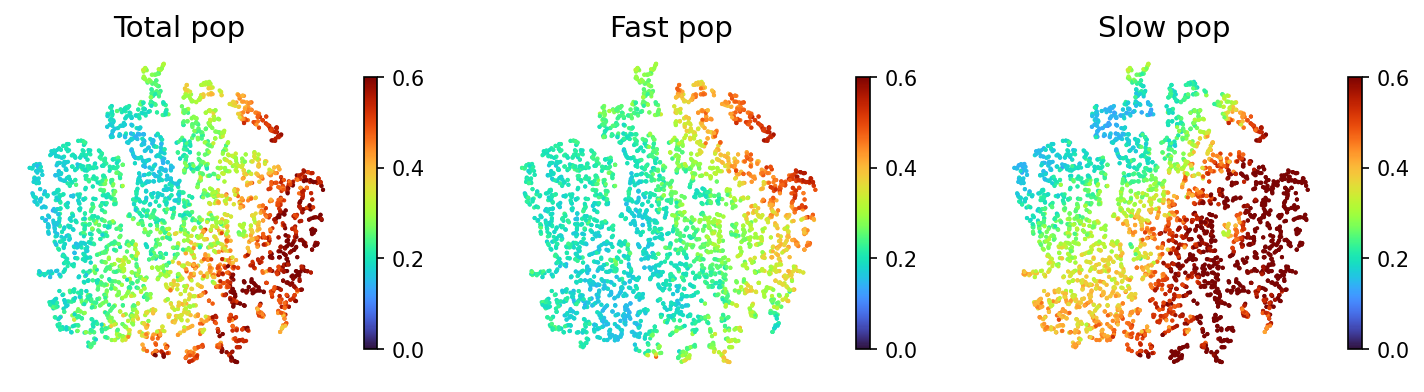

In [422]:
plt.figure(dpi=150, figsize=(12, 6))
for tp in range(3):
    nid = finder("ac2p_large(%d)"%(tp), row_names)
    print(row_names[nid])
    
    plt.subplot(1, 3, tp+1)
    embed_data(align_data[nid, :], cmap="turbo", vmin=0, vmax=0.6)
    plt.title("%s pop"%(pop_labels[tp]), fontsize=14)

plt.show()

## Test with UMAP 

In [423]:
import umap

np.random.seed(42)
fit_umap = umap.UMAP(n_neighbors=30, min_dist=0.5, n_components=2)
ufit = fit_umap.fit_transform(pdata["data"].T)

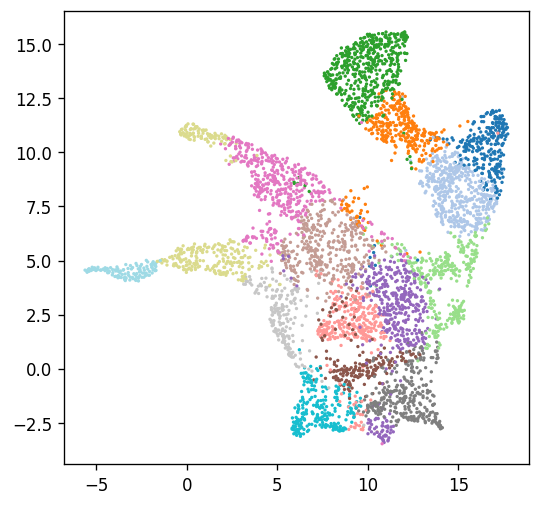

In [424]:
plt.figure(dpi=120, figsize=(5, 5))
plt.scatter(ufit[:, 0], ufit[:, 1], s=1, c=cluster_data["rcluster_id"], cmap=plt.get_cmap("tab20", 15))
plt.show()

##  

## tSNE with prob 

In [ ]:
from sklearn.manifold import TSNE

with open("./data/network.pkl", "rb") as fp:
    ntk = pkl.load(fp)
print(ntk.keys())

In [ ]:
np.random.seed(200)

tsne2d_prob = TSNE(n_components=2, init="pca", n_jobs=20, perplexity=40)
dmat = ntk["adj_mat"]
tsne_fit_prob = tsne2d_prob.fit_transform(dmat)

In [ ]:
alpha = cluster_data["rsval"].copy()
alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))
# alpha = np.ones_like(alpha)

plt.figure(dpi=120, figsize=(5, 5))
plt.scatter(tsne_fit_prob[:, 0], tsne_fit_prob[:, 1], s=1, c=cluster_data["rcluster_id"], cmap=plt.get_cmap("turbo", 15),
            alpha=alpha)
plt.axis("off")
plt.show()